# Implementation of a Devito viscoacoustic equations

## This tutorial is contributed by SENAI CIMATEC (2020)

This tutorial is based on:

<br>**Linear inversion in layered viscoacoustic media using a time‐domain method** (1994)
<br>Joakim O. Blanch and William W. Symes
<br>SEG Technical Program Expanded Abstracts
<br>https://doi.org/10.1190/1.1822695

<br>**True-amplitude prestack depth migration** (2007)
<br>Feng Deng and George A. McMechan 
<br>GEOPHYSICS Technical Papers 
<br>https://doi.org/10.1190/1.2714334

<br>**Attenuation compensation for least-squares reverse time migration using the viscoacoustic-wave equation** (2014)
<br>Gaurav Dutta and Gerard T. Schuster
<br>GEOPHYSICS Technical Papers
<br>https://doi.org/10.1190/geo2013-0414.1

<br>**Multiscale viscoacoustic waveform inversion with the second generation wavelet transform and adaptive time–space domain finite-difference method** (2014)
<br>Zhiming Ren, Yang Liu,and Qunshan Zhang
<br>Geophysical Journal International, Volume 197, Issue 2, 1 May 2014, Pages 948–974
<br>https://doi.org/10.1093/gji/ggu024

<br>**Viscoacoustic prestack reverse time migration based on the optimal time-space domain high-order finite-difference method** (2014)
<br>Yan Zhao, Yang Liu, and Zhi-Ming Ren 
<br>Appl. Geophys. 11, 50–62. 
<br>https://doi.org/10.1007/s11770-014-0414-8

<br>**A stable and efficient approach of Q reverse time migration** (2018)
<br>Yan Zhao, Ningbo Mao, and Zhiming Ren
<br>GEOPHYSICS Technical Papers
<br>https://doi.org/10.1190/geo2018-0022.1

## Introduction 

The conversion of mechanical energy to heat, occurs during the propagation of seismic waves on the subsurface, due to the viscosity of the rocks. The presence of oil and gas in these rocks causes seismic attenuations. Thus, associated effects, such as dispersion and dissipation, can significantly affect the amplitudes, as well as the phase of the seismic pulse.  However, in the seismic exploration, the subsurface has still been considered as an ideal elastic/acoustic medium, that is, disregarding its mitigating effect. In practice, the propagation of seismic waves on the subsurface is in many ways different from propagation in an ideal solid. 

For example, some subsurface rocks have anisotropic properties, are heterogeneous, porous and so on. The acoustic/elastic wave equation is not sensitive enough to describe propagation in these more complicated mediums. Generally, the viscosity of materials in the subsurface causes energy dissipation and consequently a decrease in amplitude, in addition to modifying the frequency content of the waves. This phenomenon of energy dissipation of the wave is called seismic absorption or attenuation. 

The goal of this tutorial is to perform a seismic modeling taking into account the viscosity of the medium, so that it is possible to more accurately simulate the seismic data and consequently build images with better resolution in the processing of this data, in addition to extracting more detailed information on rocky materials through seismic inversion. 

This tutorial follow three main viscoacoustic approaches in time-space domain:

- Blanch and Symes (1995) / Dutta and Schuster (2014)

- Ren et al. (2014)

- Deng and McMechan (2007)

<h1><center>Table of symbols</center></h1>

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; | Description
| :---         | :---             
|$f$                                  |Frequency                                            |
|$f_o$                                |Reference frequency                                  |
|$\omega$                             |Angular frenquency                                   |
|$\omega_0$                           |Angular Reference Frequency                          |
|$v$                                  |Velocity model                                       |
|$v_0$                                |Reference velocity at $\omega_0$                     |
|$\kappa$                             |Bulk modulus                                         |
|$g$                                  |Absorption coefficient                               |
|$\tau$                               |Relaxation time                                      |
|$\tau_\sigma$                        |Stress relaxation parameter                          |
|$\tau_\epsilon$                      |Strain relaxation parameter                          |
|$Q$                                  |Quality factor                                       |
|$\eta$                               |Viscosity                                            |
|$\rho$                               |Density                                              |
|$\nabla$                             |Nabla operator                                       |
|$P({\bf x},t)$                       |Pressure field                                       |
|$r({\bf x},t)$                       |Memory variable                                      |
|${\bf v}({\bf x},t)$                 |Particle velocity                                    |
|$S({\bf x}_s,t)$                     |Source                                               |

# Seismic modelling with Devito

Before start with the viscoacoustic approaches we will describe a setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a single source and an according set of receivers to model for the forward model. But first, we initialize some basic utilities.

In [1]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt

from devito import *
from examples.seismic.source import RickerSource, WaveletSource, TimeAxis
from examples.seismic import ModelViscoacoustic, plot_image, setup_geometry, plot_velocity

In [2]:
nx = 300
nz = 300

# Define a physical size
shape = (nx, nz)
spacing = (20., 20.)
origin = (0., 0.)
nlayers = 3
nbl = 50
space_order = 8
dtype = np.float32

# Model physical parameters:
vp = np.zeros(shape)
qp = np.zeros(shape)
rho = np.zeros(shape)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5

# Define a velocity profile in km/s
v = np.empty(shape, dtype=dtype)
v[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

qp[:] = 3.516*((v[:]*1000.)**2.2)*10**(-6) # Li's empirical formula

rho[:] = 0.31*(v[:]*1000.)**0.25 # Gardner's relation

In [3]:
#NBVAL_IGNORE_OUTPUT
model = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, b=1/rho, 
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


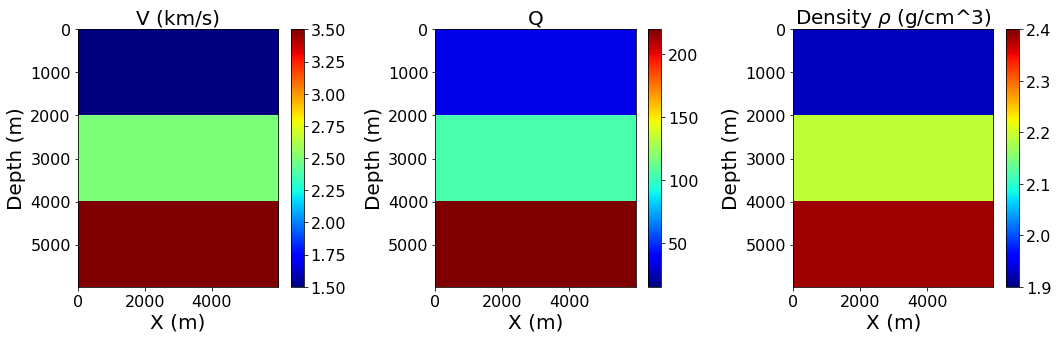

In [4]:
#NBVAL_IGNORE_OUTPUT
aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0], model.origin[0] + model.domain_size[0],
                                               model.origin[1] + model.domain_size[1], model.origin[1]]}
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

img1 = ax[0].imshow(np.transpose(model.vp.data[slices]), vmin=1.5, vmax=3.5, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"V (km/s)", fontsize=20)
ax[0].set_xlabel('X (m)', fontsize=20)
ax[0].set_ylabel('Depth (m)', fontsize=20)
ax[0].set_aspect('auto')

img2 = ax[1].imshow(np.transpose(qp), vmin=15, vmax=220, **plt_options_model)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Q", fontsize=20)
ax[1].set_xlabel('X (m)', fontsize=20)
ax[1].set_ylabel('Depth (m)', fontsize=20)
ax[1].set_aspect('auto')

img3 = ax[2].imshow(np.transpose(rho), vmin=1.9, vmax=2.4, **plt_options_model)
fig.colorbar(img3, ax=ax[2])
ax[2].set_title(r"Density $\rho$ (g/cm^3)", fontsize=20)
ax[2].set_xlabel('X (m)', fontsize=20)
ax[2].set_ylabel('Depth (m)', fontsize=20)
ax[2].set_aspect('auto')

plt.tight_layout()

In [5]:
f0 = 0.005 # peak/dominant frequency 
b = model.b
rho = 1./b

# velocity model
vp = model.vp

t_s = (sp.sqrt(1.+1./model.qp**2)-1./model.qp)/f0
t_ep = 1./(f0**2*t_s)
tt = (t_ep/t_s) - 1.

s = model.grid.stepping_dim.spacing
damp = model.damp

In [6]:
# Time step in ms and time range:
t0, tn = 0., 2000.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

In [7]:
from examples.seismic import Receiver

def src_rec(p, model):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.coordinates.data[0, -1] = 8.  

    # Create symbol for receivers
    rec = Receiver(name='rec', grid=model.grid, npoint=shape[0], time_range=time_range)

    # Prescribe even spacing for receivers along the x-axis
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec.coordinates.data[:, 1] = 8.  

    src_term = src.inject(field=p.forward, expr=(s*src))
    rec_term = rec.interpolate(expr=p)
    
    return src_term + rec_term, src, rec

Auxiliary functions for plotting data:

In [8]:
def plot_receiver(rec):
    rec_plot = rec.resample(num=1001)
    scale_for_plot = np.diag(np.linspace(1.0, 2.5, 1001)**2.0)
    # Pressure (txx + tzz) data at sea surface
    extent = [rec_plot.coordinates.data[0, 0], rec_plot.coordinates.data[-1, 0], 1e-3*tn, t0]
    aspect = rec_plot.coordinates.data[-1, 0]/(1e-3*tn)/.5

    plt.figure(figsize=(10, 10))
    plt.imshow(np.dot(scale_for_plot, rec_plot.data), vmin=-.01, vmax=.01, cmap="seismic",
           interpolation='lanczos', extent=extent, aspect=aspect)
    plt.ylabel("Time (s)", fontsize=20)
    plt.xlabel("Receiver position (m)", fontsize=20)

In [9]:
def plot_v_and_p(model, v, p):
    
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
    scale = .5*1e-3

    plt_options_model = {'extent': [model.origin[0] , model.origin[0] + model.domain_size[0],
                                    model.origin[1] + model.domain_size[1], model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

    ax[0].imshow(np.transpose(v[0].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[0].imshow(np.transpose(model.vp.data[slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[0].set_aspect('auto')
    ax[0].set_xlabel('X (m)', fontsize=20)
    ax[0].set_ylabel('Depth (m)', fontsize=20)
    ax[0].set_title(r"$v_{x}$", fontsize=20)

    ax[1].imshow(np.transpose(v[1].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[1].imshow(np.transpose(model.vp.data[slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[1].set_aspect('auto')
    ax[1].set_xlabel('X (m)', fontsize=20)
    ax[1].set_title(r"$v_{z}$", fontsize=20)

    ax[2].imshow(np.transpose(p.data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[2].imshow(np.transpose(model.vp.data[slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[2].set_aspect('auto')
    ax[2].set_xlabel('X (m)', fontsize=20)
    ax[2].set_title(r"$P$", fontsize=20)

## Blanch and Symes (1995) / Dutta and Schuster (2014)

The equations of motion for a viscoacoustic medium can be written as:

\begin{equation}
\left\{
\begin{array}{lcl}
\frac{\partial P}{\partial t} + \kappa (\tau + 1)(\nabla \cdot {\bf v}) + r = S({\bf x}_{s}, t) \\
\frac{\partial {\bf v}}{\partial t} + \frac{1}{\rho}\nabla{P} = 0 \\
\frac{\partial r}{\partial t} + \frac{1}{\tau_{\sigma}} [r + \tau \kappa (\nabla \cdot {\bf v})] = 0.
\end{array}
\right.
\label{first-order-dutta}
\end{equation}

Where $\tau = \tau_{\epsilon}/\tau_{\sigma} -1$ represents the magnitude of  $Q$. $\tau_{\epsilon}$ and $\tau_{\sigma}$ are, respectively, the stress and strain relaxation parameters, given by:

\begin{equation}
\tau_\sigma = \frac{\sqrt{Q^2+1}-1}{2 \pi f_0 Q}
\end{equation}
and
\begin{equation}
\tau_\epsilon= \frac{\sqrt{Q^2+1}+1}{2\pi f_0 Q}
\end{equation}


In [10]:
# Stencil created from Blanch and Symes (1995) / Dutta and Schuster (2014) 
def blanch_symes(model, p, r, v):

    # Bulk modulus
    bm = rho * (vp * vp)

    # Define PDE to v
    pde_v = v - s * b * grad(p)
    u_v = Eq(v.forward, damp * pde_v)    

    # Define PDE to r
    pde_r = r - s * (1. / t_s) * r - s * (1. / t_s) * tt * bm * div(v.forward)
    u_r = Eq(r.forward, damp * pde_r)

    # Define PDE to p
    pde_p = p - s * bm * (tt + 1.) * div(v.forward) - s * r.forward
    u_p = Eq(p.forward, damp * pde_p) 
    
    return [u_v, u_r, u_p]

In [11]:
# Seismic Modelling from Blanch and Symes (1995) / Dutta and Schuster (2014) viscoacoustic wave equation.
def modelling_blanch_symes(model):
    
    # Create symbols for particle velocity, pressure field, memory variable, source and receivers
    
    v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=space_order)

    p = TimeFunction(name="p", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)

    r = TimeFunction(name="r", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)
    
    # define the source injection and create interpolation expression for receivers
    
    src_rec_expr, src, rec = src_rec(p, model)
    
    eqn = blanch_symes(model, p, r, v)
    
    op = Operator(eqn + src_rec_expr, subs=model.spacing_map)
    
    op(time=time_range.num-1, dt=dt, src=src, rec=rec)
    
    return rec, v, p

In [12]:
#NBVAL_IGNORE_OUTPUT
rec, v, p = modelling_blanch_symes(model)

Operator `Kernel` run in 1.33 s


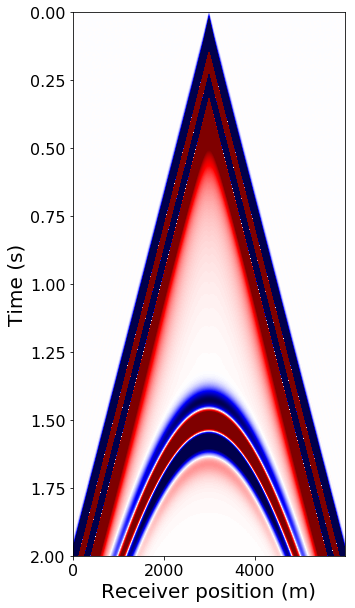

In [13]:
#NBVAL_IGNORE_OUTPUT
plot_receiver(rec)

In [14]:
assert np.isclose(np.linalg.norm(rec.data), 16, rtol=10)

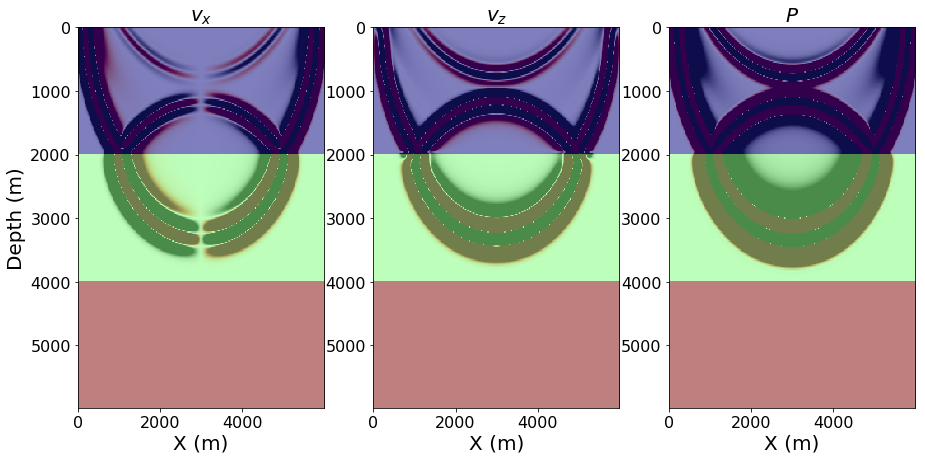

In [15]:
#NBVAL_IGNORE_OUTPUT
plot_v_and_p(model, v, p)

In [16]:
assert np.isclose(norm(v[0]), 1.8687493, atol=1e-3, rtol=0)

## Ren et al. (2014)

The viscoacoustic wave equation in time domain is written as:

\begin{equation}
\frac{\partial^{2}P}{\partial{t^2}} - v^{2}\nabla^{2}{P} - \eta\nabla^{2}\left(\frac{\partial P}{\partial t}\right) = S({\bf x}_{s}, t),
\end{equation}

where $\eta = \frac{v^2}{\omega_{0}Q}$ represents the viscosity of medium.

Considering the variable density $\rho$, the equation can be rewritten as:

\begin{equation}
\frac{\partial^{2}P}{\partial{t^2}} - \kappa \nabla \cdot \frac{1}{\rho} \nabla{P} - \eta \rho \nabla \cdot \frac{1}{\rho} \nabla \left(\frac{\partial{P}}{\partial{t}}\right) = S({\bf x}_{s}, t).
\end{equation}

The equation can be written using a first order formulation, given by:

\begin{equation}
\left\{
\begin{array}{ll}
\frac{\partial P}{\partial t} + \kappa \nabla \cdot {\bf v} - \eta \rho \nabla \cdot \frac{1}{\rho} \nabla{P} = S({\bf x}_{s}, t) \\
\frac{\partial {\bf v}}{\partial t} + \frac{1}{\rho} \nabla{P} = 0
\end{array}
\right.
\end{equation}

In [17]:
# Stencil created from Ren et al. (2014) viscoacoustic wave equation.
def ren(model, p, v):

    # Angular frequency 
    w = 2. * np.pi * f0

    # Define PDE to v
    pde_v = v - s * b * grad(p)
    u_v = Eq(v.forward, damp * pde_v)

    # Define PDE to p
    pde_p = p - s * vp * vp * rho * div(v.forward) + s * \
            ((vp * vp * rho) / (w * model.qp)) * div(b * grad(p))

    u_p = Eq(p.forward, damp * pde_p) 
    
    return [u_v, u_p]

In [18]:
# Seismic Modelling from Ren et al. (2014) viscoacoustic wave equation.
def modelling_ren(model):
    
    # Create symbols for particle velocity, pressure field, source and receivers

    v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=space_order)

    p = TimeFunction(name="p", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)

    # define the source injection and create interpolation expression for receivers
    
    src_rec_expr, src, rec = src_rec(p, model)
    
    eqn = ren(model, p, v)
    
    op = Operator(eqn + src_rec_expr, subs=model.spacing_map)
    
    op(time=time_range.num-1, dt=dt, src=src, rec=rec)
    
    return rec, v, p

In [19]:
#NBVAL_IGNORE_OUTPUT
rec, v, p = modelling_ren(model)

Operator `Kernel` run in 2.96 s


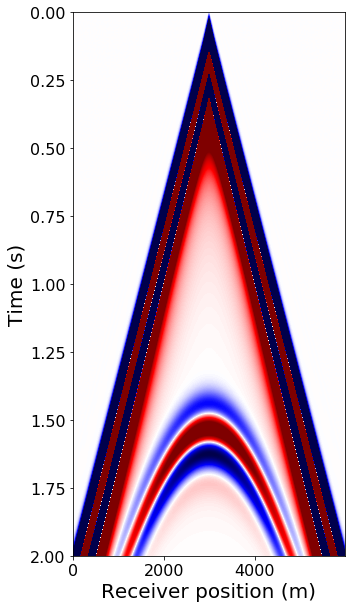

In [20]:
#NBVAL_IGNORE_OUTPUT
plot_receiver(rec)

In [21]:
assert np.isclose(np.linalg.norm(rec.data), 15, rtol=10)

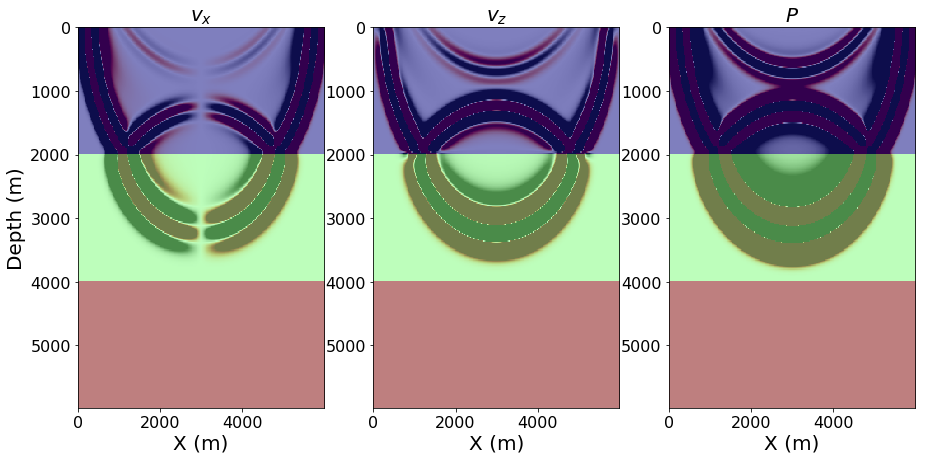

In [22]:
#NBVAL_IGNORE_OUTPUT
plot_v_and_p(model, v, p)

In [23]:
assert np.isclose(norm(v[0]), 1.0587339, atol=1e-3, rtol=0)

## Deng and McMechan (2007)

The viscoacoustic wave equation for the propagating pressure $P$ in the time-space domain:

\begin{equation}
\frac{1}{v^2}\frac{\partial^{2}P}{\partial{t^2}} - \nabla^{2}P + \frac{g}{v}\frac{\partial P}{\partial{t}}  = S({\bf x}_{s}, t),
\label{eq-deng}
\end{equation}

where $g$ is the absorption coefficient, given by:

\begin{equation}
g = \frac{2\pi f_{0}}{vQ},
\end{equation}

The equation can be written using a first order formulation, given by:

\begin{equation}
\left\{
\begin{array}{lcl}
\frac{\partial P}{\partial t} + \kappa (\nabla \cdot {\bf v}) + \frac{2\pi f_{0}}{Q}P= S({\bf x}_{s}, t) \\
\frac{\partial {\bf v}}{\partial t} + \frac{1}{\rho}\nabla{P} = 0 \\
\end{array}
\right.
\end{equation}


In [24]:
# Stencil created from Deng and McMechan (2007) viscoacoustic wave equation.
def deng_mcmechan(model, p, v):

    # Angular frequency 
    w = 2. * np.pi * f0

    # Define PDE to v
    pde_v = v - s * b * grad(p)
    u_v = Eq(v.forward, damp * pde_v)

    # Define PDE to p
    pde_p = p - s * vp * vp * rho * div(v.forward) - s * (w / model.qp) * p
    u_p = Eq(p.forward, damp * pde_p) 
    
    return [u_v, u_p]

In [25]:
# Seismic Modelling from Deng and McMechan (2007) viscoacoustic wave equation.
def modelling_deng_mcmechan(model):
    
    # Create symbols for particle velocity, pressure field, source and receivers
    
    v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=space_order)

    p = TimeFunction(name="p", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)

    # define the source injection and create interpolation expression for receivers
    
    src_rec_expr, src, rec = src_rec(p, model)
    
    eqn = deng_mcmechan(model, p, v)
    
    op = Operator(eqn + src_rec_expr, subs=model.spacing_map)
    
    op(time=time_range.num-1, dt=dt, src=src, rec=rec)
    
    return rec, v, p

In [26]:
#NBVAL_IGNORE_OUTPUT
rec, v, p = modelling_deng_mcmechan(model)

Operator `Kernel` run in 1.13 s


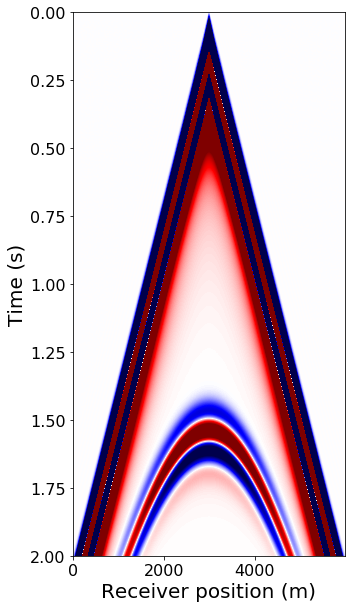

In [27]:
#NBVAL_IGNORE_OUTPUT
plot_receiver(rec)

In [28]:
assert np.isclose(np.linalg.norm(rec.data), 16, rtol=10)

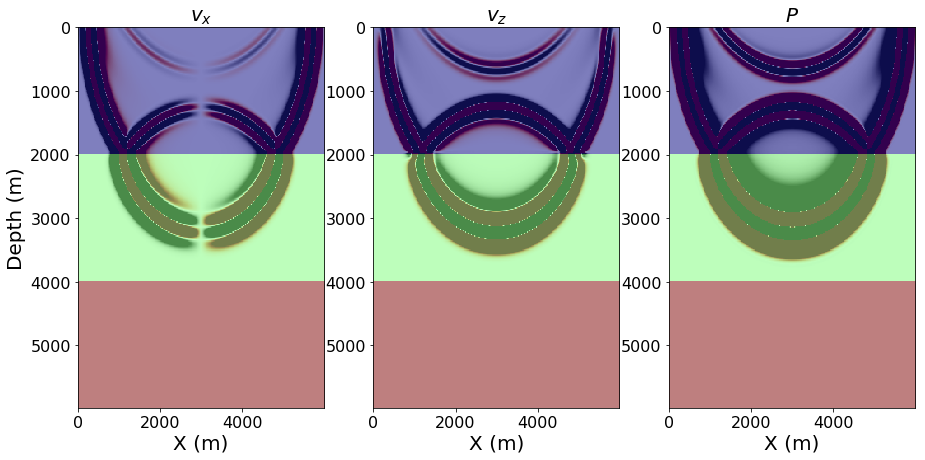

In [29]:
#NBVAL_IGNORE_OUTPUT
plot_v_and_p(model, v, p)

In [30]:
assert np.isclose(norm(v[0]), 1.126901, atol=1e-3, rtol=0)

# More references

[1] https://academic.oup.com/gji/article/197/2/948/616510

[2] https://link.springer.com/article/10.1007/s11770-014-0414-8

[3] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf